# HR ATTRIBUTION

In [27]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

# 1.) Import, split data into X/y, plot y data as bar charts, turn X categorical variables binary and tts.

In [2]:
df = pd.read_csv("HR_Analytics.csv")

In [3]:
y = df[["Attrition"]].copy()
X = df.drop("Attrition", axis = 1)

In [4]:
y["Attrition"] = [1 if i == "Yes" else 0 for i in y["Attrition"]]

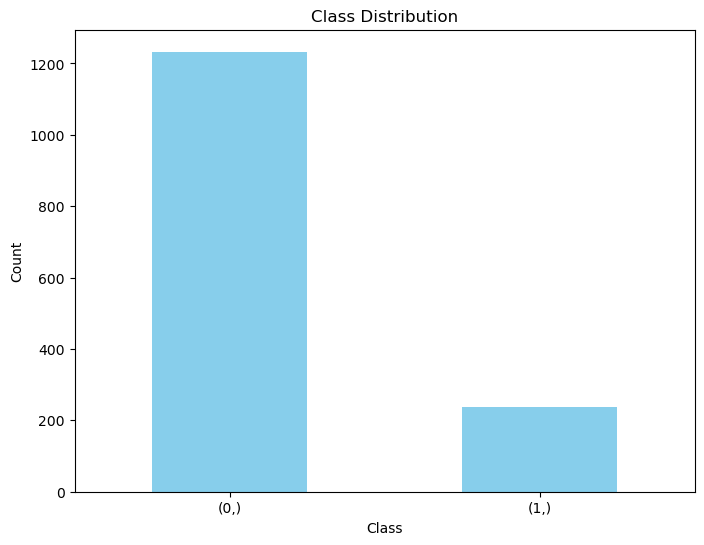

In [5]:
class_counts = y.value_counts()


plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Remove rotation of x-axis labels
plt.show()



In [6]:
# Step 1: Identify string columns
string_columns = X.columns[X.dtypes == 'object']

# Step 2: Convert string columns to categorical
for col in string_columns:
    X[col] = pd.Categorical(X[col])

# Step 3: Create dummy columns
X = pd.get_dummies(X, columns=string_columns, prefix=string_columns,drop_first=True)




In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,
 y, test_size=0.20, random_state=42)


# 2.) Using the default Decision Tree. What is the IN/Out of Sample accuracy?

In [8]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  1.0
OUT OF SAMPLE ACCURACY :  0.79


# 3.) Run a grid search cross validation using F1 score to find the best metrics. What is the In and Out of Sample now?

In [9]:

# Define the hyperparameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),  # Range of max_depth values to try
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


dt_classifier = DecisionTreeClassifier(random_state=42)

scoring = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring, cv=5)

grid_search.fit(x_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)


Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1-Score: 0.8214764475510983


In [10]:
clf = tree.DecisionTreeClassifier(**best_params, random_state =42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  0.91
OUT OF SAMPLE ACCURACY :  0.83


# 4.) Plot ......

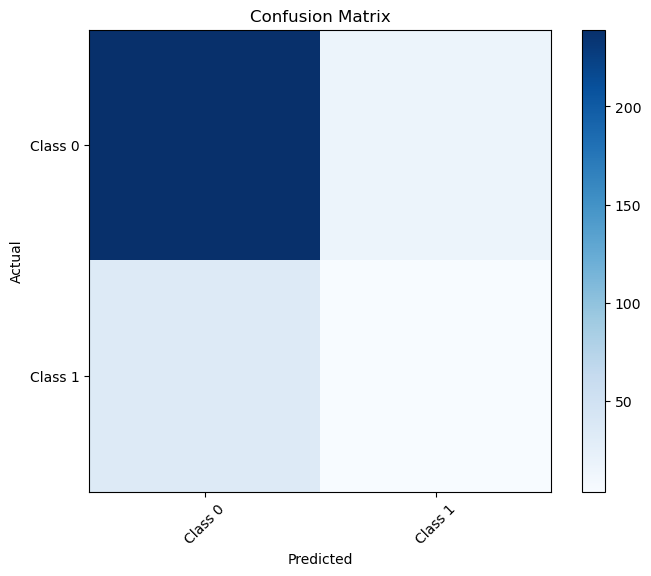

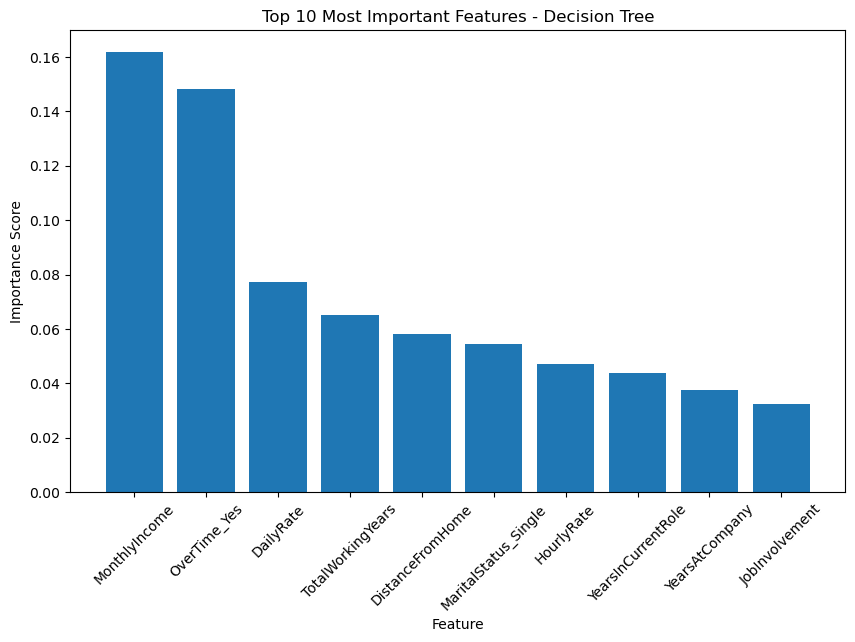

In [17]:
# Make predictions on the test data
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
feature_importance = clf.feature_importances_
 
# Sort features by importance and select the top 10
top_n = 10
top_feature_indices = np.argsort(feature_importance)[::-1][:top_n]
top_feature_names = X.columns[top_feature_indices]
top_feature_importance = feature_importance[top_feature_indices]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.xticks(rotation=45)
plt.show()



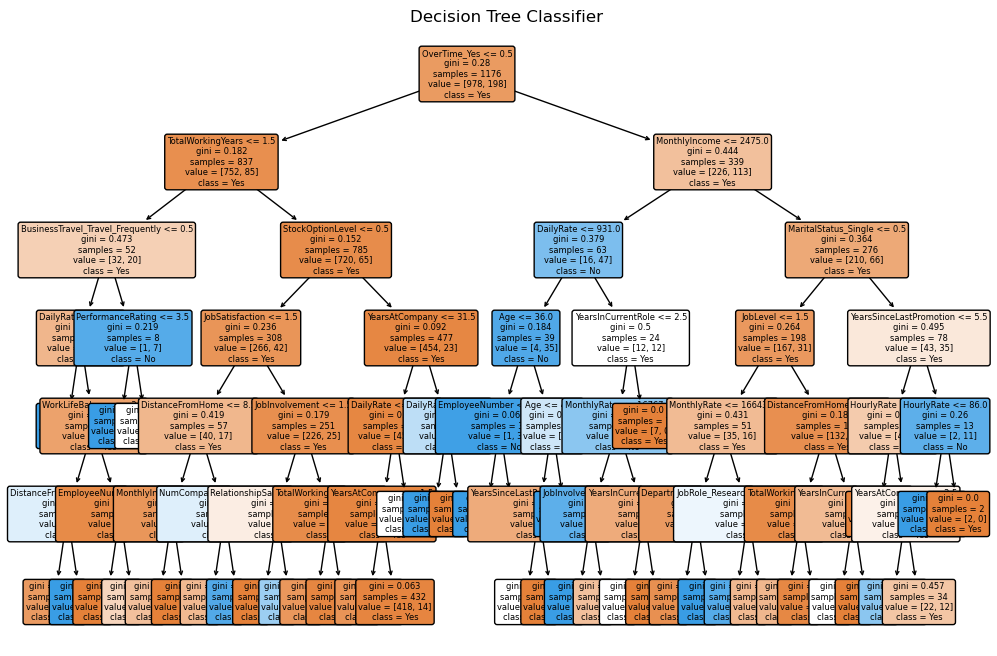

In [42]:
#Plot the Decision Tree for better visualization of the selected features
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns.tolist(), class_names=["Yes", "No"], rounded=True, fontsize = 6) 
plt.title('Decision Tree Classifier')
plt.show()

# 5.) Looking at the graphs. what would be your suggestions to try to improve customer retention? What additional information would you need for a better plan. Plot anything you think would assist in your assessment.

## ANSWER :

In [31]:
def calculate_correlation(X, feature_name, y):
    feature = X[feature_name]
    
    
    if feature.dtype.kind in 'bifc':
      
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]

      
        if y.dtype.kind in 'bifc' and len(feature) == len(y):
           
            valid_indices = ~pd.isnull(feature) & ~pd.isnull(y)
            coef, _ = pearsonr(feature[valid_indices], y[valid_indices])
            return coef
        else:
            return None  
    else:
        return None


calculate_correlation(x_train, "MonthlyIncome", y_train)

-0.15981961774158915

In [32]:
calculate_correlation(x_train, "OverTime_Yes", y_train)

0.28056715445380287

Based on the analysis, it is evident that increasing employees' monthly salaries contributes to reducing the rate of attrition. Additionally, lowering the number of employees who work overtime can also decrease attrition rates, as there is a positive correlation with "OverTime_Yes".

# 6.) Using the Training Data, if they made everyone work overtime. What would have been the expected difference in client retention?

In [33]:
x_train_experiment2 = x_train.copy()
x_train_experiment2['OverTime_Yes'] = 1.
y_pred = clf.predict(x_train)
y_pred_experiment2 = clf.predict(x_train_experiment2)
diff2 = sum(y_pred - y_pred_experiment2)
print('The number of attrition will rise by', -diff2, ', if they made everyone works overtime')

The number of attrition will rise by 141 , if they made everyone works overtime


In [34]:
x_train_experiment = x_train.copy()
x_train_experiment['OverTime_Yes'] = 0.
y_pred = clf.predict(x_train)
y_pred_experiment = clf.predict(x_train_experiment)
diff = sum(y_pred - y_pred_experiment)
print('The number of attrition will drop by', diff, ', if they made no one works overtime.')

The number of attrition will drop by 59 , if they made no one works overtime.


# 7.) If they company loses an employee, there is a cost to train a new employee for a role ~2.8 * their monthly income.
# To make someone not work overtime costs the company 2K per person.
# Is it profitable for the company to remove overtime? If so/not by how much? 
# What do you suggest to maximize company profits?

In [36]:
x_train_experiment['Y'] = y_pred
x_train_experiment['Y_exp'] = y_pred_experiment

x_train_experiment['RetChange'] = x_train_experiment['Y'] - x_train_experiment['Y_exp']
saving = sum(2.8 * x_train_experiment['RetChange'] * x_train_experiment['MonthlyIncome'])
cost = len(x_train[x_train['OverTime_Yes'] == 1]) * 2000

saving - cost

-117593.99999999977

Analyzing the figures, it's clear that the financial savings are outweighed by the costs incurred by the company when eliminating overtime. Thus, with the primary goal of profit maximization, it's advisable for the company to have all employees work overtime.

# 8.) Use your model and get the expected change in retention for raising and lowering peoples income. Plot the outcome of the experiment. Comment on the outcome of the experiment and your suggestions to maximize profit.

In [40]:
profits = []
raise_amounts = []
for raise_amount in range(-1000, 1000, 10):
  x_train_experiment3 = x_train.copy()
  x_train_experiment3['MonthlyIncome'] = x_train_experiment['MonthlyIncome'] + raise_amount
  y_pred = clf.predict(x_train)
  y_pred_experiment3 = clf.predict(x_train_experiment3)
  x_train_experiment3['Y'] = y_pred
  x_train_experiment3['Y_exp'] = y_pred_experiment3
 
  saving = sum(-2.8 * x_train_experiment['RetChange'] * x_train_experiment['MonthlyIncome'])
  cost = len(x_train) * raise_amount
  profits.append(saving - cost)
  raise_amounts.append(raise_amount)

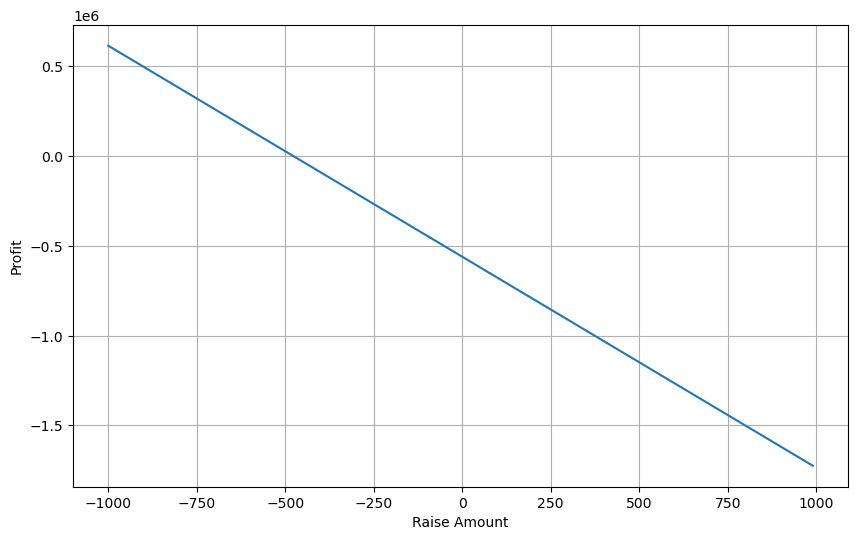

In [41]:
plt.figure(figsize = (10, 6))
plt.plot(raise_amounts, profits)
plt.xlabel('Raise Amount')
plt.ylabel('Profit')
plt.grid(True)

As we elevate the income levels, the company's profit margin diminishes. This indicates that the propensity of employees to quit due to reduced income isn't significant enough to impact the company's profitability negatively. Therefore, reducing salaries emerges as an effective strategy to enhance profit margins, suggesting that income should be minimized as much as feasible.